Bin's comment:

**NOT COMPLETED**

Last modified on 4/13

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet4(nn.Module):
    def __init__(self, n_channels=4, n_classes=5, bilinear=False):
        super(UNet4, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

class UNet3(nn.Module):
    def __init__(self, n_channels=4, n_classes=5, bilinear=False):
        super(UNet3, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.outc = torch.utils.checkpoint(self.outc)


In [2]:
import math
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import SimpleITK as sitk
import torch.optim as optim
import torchvision
from copy import deepcopy
from tensorflow.keras.models import load_model
denoising_model = load_model('denoising-model', compile=False)

In [3]:
class Config():
    batch_size = 16
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = 6
    warmup = 0.1
    lr = 1e-5
    T_0 = 100  # period of the first restart, we do not want it to restart, so we set it a big number
    T_mult = 1  # period multiplier, it does not matter
    eta_min = lr/10  # minimum learning rate
    len_train_dataloader = None
    len_valid_dataloader = None

In [4]:
# Set SEED here # to be completed

In [5]:
DATASET_PATH = 'dataset'
TRAIN_X_PATH = os.path.join(DATASET_PATH, 'X_train_input')
VALID_X_PATH = os.path.join(DATASET_PATH, 'X_test_input')
TRAIN_Y_PATH = os.path.join(DATASET_PATH, 'X_train_target')
VALID_Y_PATH = os.path.join(DATASET_PATH, 'X_test_target')

In [6]:
len_train = len(os.listdir(TRAIN_X_PATH))
Config.len_train_dataloader = len_train//Config.batch_size
len_train

35340

In [7]:
len_valid = len(os.listdir(VALID_X_PATH))
Config.len_valid_dataloader = len_valid//Config.batch_size
len_valid

8835

The index of TRAIN SET ranges from 0 to 35339 (end included)

The index of VALID SET ranges from 0 to 8834 (end included)

In [8]:
def image_loader(mode, x_or_y, index):
    """
    Return the numpy image given the information.
    mode: 'train', 'valid' or 'test'
    x_or_y: 'x' or 'y', 'x' stands for the input and 'y' stands for the target
    index: int, the index of the image
    """
    if mode == 'train':
        if x_or_y == 'x':
            filepath = os.path.join(TRAIN_X_PATH, os.path.basename(TRAIN_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(TRAIN_Y_PATH, os.path.basename(TRAIN_Y_PATH)+'_'+str(index)+'.npy')
    elif mode == 'valid':
        if x_or_y == 'x':
            filepath = os.path.join(VALID_X_PATH, os.path.basename(VALID_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(VALID_Y_PATH, os.path.basename(VALID_Y_PATH)+'_'+str(index)+'.npy')
    else:
        raise ValueError("The first or the second parameter is not valid")
        
    if not isinstance(index, int):
        raise TypeError("Index should be an integer")
    
    if mode == 'train' and (index < 0 or index > 35339):
            raise IndexError("Image index out of range 0 - 35339")
            
    if mode == 'valid' and (index < 0 or index > 8834):
            raise IndexError("Image index out of range 0 - 8834")
    
    return np.load(filepath)

In [9]:
img_example = image_loader('valid', 'y', 560)

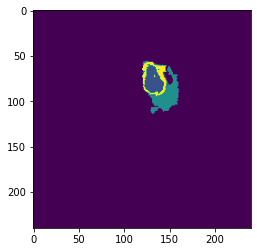

In [10]:
plt.imshow(img_example)

In [11]:
image_loader('train', 'y', 6164).shape

(240, 240)

In [12]:
image_loader('train', 'x', 6164).shape

(240, 240, 4)

**Bin's comment:**

SimpleITK is a widely used package to transform medical images


I dont know whether it is slower than other packages like torchvision transform
You may define other transformation functions and compare them

##### Tony's Comment:
Pytorch seems to work best for data augmentation

In [13]:
# Pytorch version
# --------------------
# This version is fast and more reliable than SITK version
# Applies several random tansformations to an image and the label
# - Gaussian blur : image only
# - Rotation : image and label
# - Translation : image and label
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """
    try:
        # pytorch likes input to be in [C, H, W]
        input_layers = [input_array[i,:,:] for i in range(input_array.shape[0])]
        label_layers = [label_array]
        stacked_layers = np.array(input_layers + label_layers)
        stacked_tensor = torch.tensor(stacked_layers)

        # Gaussian blur
        blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1))
        # transformed = blurT.forward(input_tensor).numpy()

        # slight rotation
        rotationT = torchvision.transforms.RandomRotation(degrees = (-5,5))
        # transformed = rotationT.forward(input_tensor).numpy()

        # slight translation
        translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, 0.05))
        # transformed = translateT.forward(input_tensor).numpy()

        # apply transformations
        combinedT = torchvision.transforms.Compose([rotationT, translateT])
        transformed_stacked = combinedT(stacked_tensor)
        transformed_input = transformed_stacked[0:-1, :,:]
        transformed_input = blurT.forward(transformed_input).numpy() # add blur to input
        transformed_label = transformed_stacked[-1, :,:].numpy()

        # # turn back into original shape
        # transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])
    
    except:
        transformed_input = input_array
        transformed_label = label_array

    return transformed_input, transformed_label

In [14]:
# SimpleITK Version
# ------------------
# Broken: Use the pytorch version unless this one gets fixed
def transformITK(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """

    # stack input and label so they can be modified togther
    stacked = np.zeros((input_array.shape[0], input_array.shape[1], input_array.shape[2] + 1))
    stacked[:,:,:-1] = input_array
    stacked[:,:,-1] = label_array

    # transform to simpleITK image
    image = sitk.GetImageFromArray(stacked)

    # get info about image
    width, height, depth = image.GetSize()
    image_center =  image.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                          int(np.ceil(height/2)),
                                          int(np.ceil(depth/2))))

    # set transformation parameters
    sigma_max = 0.01
    sigma_min = 1
    rot_max = -5 # in degrees
    rot_min = 5 # in degrees
    trnsl_x_max = 0.5
    trnsl_x_min = -0.5
    trnsl_y_max = 0.5
    trnsl_y_min = -0.5

    sigma = (sigma_max - sigma_min) * np.random.random_sample() + sigma_min
    random_degree = (rot_max - rot_min) * np.random.random_sample() + rot_min
    random_x = (trnsl_x_max - trnsl_x_min) * np.random.random_sample() + trnsl_x_min
    random_y = (trnsl_y_max - trnsl_y_min) * np.random.random_sample() + trnsl_y_min
    translation = (random_x, random_y, 0)

    # preform rotation and translation on both
    rotation_angle = np.deg2rad(random_degree)
    euler_transform = sitk.Euler3DTransform(image_center, rotation_angle, 0, 0, translation)
    reference_image = image
    interpolator = sitk.sitkBSpline
    default_value = 0
    transformed = sitk.Resample(image, reference_image, euler_transform,
                     interpolator, default_value)

    # seperate input and label
    transformed_stacked = sitk.GetArrayFromImage(transformed)
    transformed_input = transformed_stacked[:,:,0:-1]
    transformed_label = transformed_stacked[:,:,-1]

    # preform gaussion blur on only input
    input_image = sitk.GetImageFromArray(transformed_input)
    gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussian.SetSigma(sigma)
    transformed_image = gaussian.Execute(input_image)
    
    # turn back into numpy array
    transformed_input = sitk.GetArrayFromImage(transformed_image)
    
    return transformed_input, transformed_label

In [15]:
for idx in range(100):
    img = image_loader('train', 'x', idx)
    label = image_loader('train', 'y', idx)
    img_reordered = img.transpose((2, 0, 1))
    # print(img_reordered.shape)
    # print(label.shape)
    # print(img.dtype)
    transformed_input, transformed_label = transform(img_reordered, label)
    # print(transformed_input.shape)
    # print(transformed_label.shape)
    # transformed_inputITK, transformed_labelITK = transformITK(img, label)

    # turn back into original shape
    transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])
    # print(transformed_input_orig.shape)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


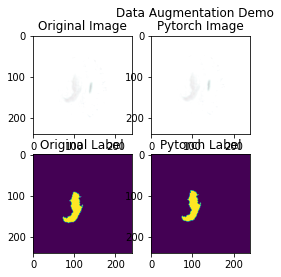

In [16]:
plt.subplot(2,3,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(2,3,2)
plt.imshow(transformed_input_orig)
plt.title("Pytorch Image")

# plt.subplot(2,3,3)
# plt.imshow(transformed_inputITK)
# plt.title("SITK Image")

plt.subplot(2,3,4)
plt.imshow(label)
plt.title("Original Label")

plt.subplot(2,3,5)
plt.imshow(transformed_label)
plt.title("Pytorch Label")

# plt.subplot(2,3,6)
# plt.imshow(transformed_labelITK)
# plt.title("SITK Label")

plt.suptitle("Data Augmentation Demo")
plt.show()

In [17]:
print(type(transformed_input))
print(transformed_input.dtype)

<class 'numpy.ndarray'>
float32


In [18]:
class TrainDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_train

    def __getitem__(self, idx):
        x, y = image_loader('train', 'x', idx), image_loader('train', 'y', idx)
        x = denoising_model.predict(np.array([x]))[0]
        x = x.transpose((2, 0, 1))
        x, y = transform(x, y)
        return x, y # NOTE the permute, => Batch*Channel*Wright*Height
    
class ValidDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_valid

    def __getitem__(self, idx):
        x, y = image_loader('valid', 'x', idx), image_loader('valid', 'y', idx)
        x = denoising_model.predict(np.array([x]))[0]
        x = x.transpose((2, 0, 1))
        return x,y

train_dataset = TrainDataset()
valid_dataset = ValidDataset()
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)

In [19]:
#Test the model
#net = UNet3(4, 5) # 4 channels, 5 classes (label 3 actually is ingored)
#y = net(torch.randn(8,4,240,240))
#_, y = torch.max(y, 1)
#print(y.size())
#del net, y

In [20]:
#The F1 score is the Dice coefficient of the set of retrieved items and the set of relevant items.

In [21]:
from sklearn.metrics import classification_report

device=Config.device

#model = UNet4(4,5)
#model = model.load_state_dict(torch.load('UNet4, Epoch5, loss 0p0721.pt'))

model = UNet4()
model = torch.load('UNet4, Epoch5, loss 0p0721.pt')


bestLoss = 1000000
model.to(device)



if True:
    model.eval()
    with torch.no_grad():
        total_pred = []
        total_target = []
        for j, (inputs, targets) in enumerate(valid_dataloader):
            inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)

            # forward
            outputs = model(inputs)
            result = torch.argmax(outputs.detach(), dim=1)
            
            pred_numpy=result.cpu().numpy().flatten().tolist()
            target_numpy=targets.cpu().numpy().flatten().tolist()
            total_pred.append(pred_numpy)
            total_target.append(target_numpy)
            
del model
torch.cuda.empty_cache()

total_pred = np.concatenate(total_pred)
total_target = np.concatenate(total_target)


report = classification_report(total_target, total_pred, digits=3, target_names = ['Background', 'NCR/NET', 'ED', 'ET'])
print(report)

              precision    recall  f1-score   support

  Background      0.997     0.995     0.996 502465142
     NCR/NET      0.503     0.511     0.507   1632930
          ED      0.429     0.531     0.474   3624115
          ET      0.441     0.571     0.498   1173813

    accuracy                          0.989 508896000
   macro avg      0.592     0.652     0.619 508896000
weighted avg      0.990     0.989     0.989 508896000

